# Training

This is code (in progress) for building and training the neural network.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
from clr_callback import *
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K  
from tensorflow.keras.optimizers import * 
# import keras_one_cycle_clr as ktool
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%matplotlib inline 

## Loading Files

In [2]:
# Dataset to train and test on
dataset = h5py.File('/data/jchishol/Jenna_Data/variables_ttbar_parton_e+mjets.h5','r')

# Numpy array of [max,mean] for each variable
X_maxmean = np.load('X_maxmean_parton_e+mjets.npy')
Y_maxmean = np.load('Y_maxmean_parton_e+mjets.npy')

## Useful Variables

In [3]:
# X and Y variables to be used
X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_isbtag', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_isbtag', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
Y_length = len(Y_keys)
X_length = len(X_keys)

# Variables keys, needed for helper codes
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
isbtag_keys = list(filter(lambda a: 'isbtag' in a, dataset.keys()))

# Number of events in the dataset
size = np.array(dataset.get('th_pt')).size
crop0 = size

## Scale the Data

In [4]:
import normalize
import shape_timesteps

# Scales data set to be between -1 and 1, with a mean of 0
Scaler = normalize.Scale_variables()
X_total, X_names = Scaler.scale_arrays(X_keys, X_maxmean)
Y_total, Y_names = Scaler.scale_arrays(Y_keys, Y_maxmean)

## Split Data Into Training and Testing

In [5]:
# Set how the data will be split
split = int(np.floor(0.95*crop0)) # 80/20 split ? (wouldn't this be 95/5 split?)

# Split into testing and training data for Y
trainY, testY = Y_total[0:split,:], Y_total[split:,:]

# Split up jets and other for X
timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

# Split into testing and training for jets and other
trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]

## Histograms of Scaled Input X and Y Variables

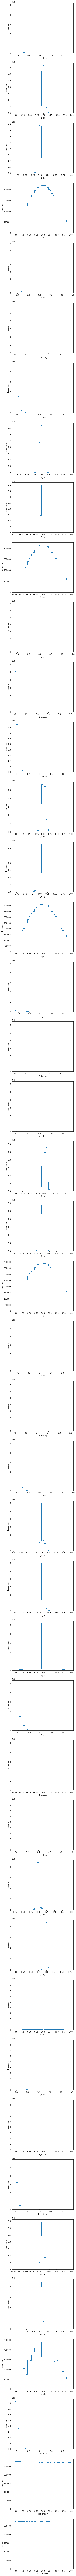

In [6]:
# Define whether or not to plot
show = True

# Plot histograms
if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

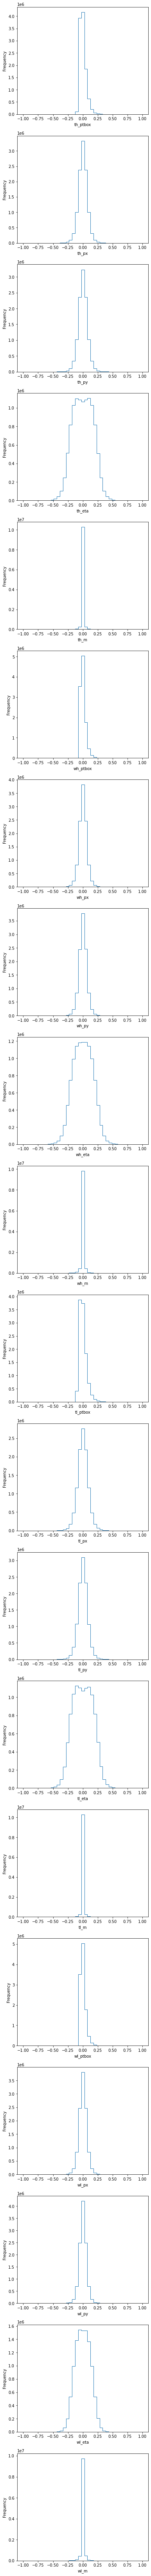

In [7]:
# Define whether or not to plot
show = True

# Define bins for different variables
other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

# Plot histograms
if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

## Build the Model

In [8]:
def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    Maskshape = Reshape((trainX_jets.shape[1], trainX_jets.shape[2]))(Mask)
    other_input = Input(shape=(trainX_other.shape[1]))
    flat_jets =  Flatten()(jet_input)
    concat0 = concatenate([other_input, flat_jets])
    PreDense1 = Dense(256, activation='relu')(concat0)
    PreDense2 = Dense(256, activation='relu')(PreDense1)
    PreDense3 = Dense(trainX_jets.shape[1], activation='sigmoid')(PreDense2)
    Shape_Dot = Reshape((-1,1))(PreDense3)
    
    TDDense11 = TimeDistributed(Dense(128, activation='relu'))(Maskshape)
    TDDense12 = TimeDistributed(Dense(64, activation='relu'))(TDDense11)
    Dot_jets = Multiply()([Shape_Dot, TDDense12])
    TDDense13 = TimeDistributed(Dense(256, activation='relu'))(Dot_jets)
    TDDense14= TimeDistributed(Dense(256, activation='relu'))(TDDense13)
    flat_right = Flatten()(TDDense14)
    
    Dense21 = Dense(128, activation='relu')(other_input)
    Dense22 = Dense(64, activation='relu')(Dense21)
    flat_other = Flatten()(Dense22)
    
    concat = concatenate([flat_other, flat_right])
    
    ldense1 = Dense(256, activation='relu')(concat)
    ldense2 = Dense(128, activation='relu')(ldense1)
    loutput = Dense(len(Y_names)//2)(ldense2)
    
    hconcat = concatenate([loutput, concat])
    hdense1 = Dense(256, activation='relu')(hconcat)
    hdense2 = Dense(128, activation='relu')(hdense1)
    houtput = Dense(len(Y_names)//2)(hdense2)
    
    output = concatenate([houtput, loutput])
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    
    # Define loss function
    def loss_fc(true, pred):
        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    
    # lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=5000,decay_rate=0.6)
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-3, decay_steps=10000,end_learning_rate=5e-5,power=0.25)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='mae', optimizer= optimizer, metrics=['mse'])
    
    return model 

# Define loss function (again?)
def loss_fc(true, pred):
        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    
# Load or build model
#model = keras.models.load_model('new_model.keras', custom_objects={'loss_fc':loss_fc})
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 6)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 36)           0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 43)           0           input_2[0][0]                    
                                                                 flatten[0][0]                

## Fit the Model 

In [9]:
# Set when to stop (has to do with loss?)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)  # patience=4 means stop training after 4 epochs with no improvement
clr_triangular = CyclicLR(base_lr=1e-5, max_lr=1e-4, step_size=5000, mode='exp_range',gamma=0.9999)
# class_weight = {0:2, 1:1, 2:1, 3:1, 4:1, 5:2, 6:1, 7:1, 8:1, 9:1, 10:2, 11:1, 12:1, 13:1, 14:1, 15:2, 16:1, 17:1, 18:1, 19:1}

# Set number of epochs (runs through?)
Epochs= 256

# del X_total
# del Y_total
# def loss(true, pred):
#     return K.mean(K.square(true-pred)*(1+K.square(true)))


# Fit the model (i.e. TRAIN the model)
history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs,
                   validation_data=([testX_jets, testX_other], testY), shuffle=True, callbacks=[early_stop],
                    batch_size=1000)

Epoch 1/256
10459/10459 [==============================] - 70s 6ms/step - loss: 0.0249 - mse: 0.0019 - val_loss: 0.0215 - val_mse: 0.0016
Epoch 2/256
10459/10459 [==============================] - 66s 6ms/step - loss: 0.0213 - mse: 0.0015 - val_loss: 0.0213 - val_mse: 0.0016
Epoch 3/256
10459/10459 [==============================] - 66s 6ms/step - loss: 0.0212 - mse: 0.0015 - val_loss: 0.0213 - val_mse: 0.0016
Epoch 4/256
10459/10459 [==============================] - 66s 6ms/step - loss: 0.0211 - mse: 0.0015 - val_loss: 0.0212 - val_mse: 0.0016
Epoch 5/256
10459/10459 [==============================] - 66s 6ms/step - loss: 0.0210 - mse: 0.0015 - val_loss: 0.0212 - val_mse: 0.0015
Epoch 6/256
10459/10459 [==============================] - 66s 6ms/step - loss: 0.0210 - mse: 0.0015 - val_loss: 0.0211 - val_mse: 0.0015
Epoch 7/256
10459/10459 [==============================] - 66s 6ms/step - loss: 0.0209 - mse: 0.0015 - val_loss: 0.0211 - val_mse: 0.0015
Epoch 8/256
10459/10459 [=========

10459/10459 [==============================] - 66s 6ms/step - loss: 0.0200 - mse: 0.0014 - val_loss: 0.0204 - val_mse: 0.0015
Epoch 61/256
10459/10459 [==============================] - 66s 6ms/step - loss: 0.0200 - mse: 0.0014 - val_loss: 0.0204 - val_mse: 0.0015
Epoch 62/256
10459/10459 [==============================] - 66s 6ms/step - loss: 0.0200 - mse: 0.0014 - val_loss: 0.0204 - val_mse: 0.0015
Epoch 63/256
10459/10459 [==============================] - 66s 6ms/step - loss: 0.0200 - mse: 0.0014 - val_loss: 0.0204 - val_mse: 0.0015
Epoch 64/256
10459/10459 [==============================] - 66s 6ms/step - loss: 0.0200 - mse: 0.0014 - val_loss: 0.0204 - val_mse: 0.0015
Epoch 65/256
10459/10459 [==============================] - 66s 6ms/step - loss: 0.0200 - mse: 0.0014 - val_loss: 0.0204 - val_mse: 0.0015
Epoch 66/256
10459/10459 [==============================] - 66s 6ms/step - loss: 0.0200 - mse: 0.0014 - val_loss: 0.0204 - val_mse: 0.0015
Epoch 67/256
10459/10459 [==============

## Save the Model

In [10]:
model.save('new_model_2.keras')

## Plot Training Stats 

In [ ]:
#plt.xlabel('Training Iterations')
#plt.ylabel('Learning Rate')
#plt.title("CLR - 'triangular' Policy")
#plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

Text(0.5, 1.0, 'MSE loss')

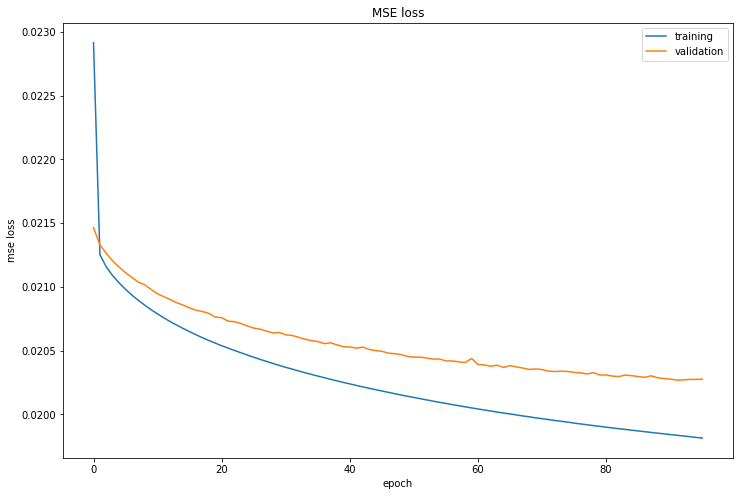

In [11]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

# Testing and Plots

This part of the code tests the machine learning and data.

## Predict

In [12]:
# Predict using un-scaled variables
predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY 

# Predict using scaled variables (on all data)
total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
Y_total, _ = Scaler.scale_arrays(Y_keys, Y_maxmean)

# Unscale the scaled predictions
predictions_origscale = Scaler.invscale_arrays(total_predictions, Y_names, Y_maxmean)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_total, Y_names, Y_maxmean)[split:,:]

In [ ]:
# Do I need this??????

#from tensorflow.keras.models import Model

#layer_name = 'dense_2'
#intermediate_layer_model = Model(inputs=model.input,
#                                 outputs=model.get_layer(layer_name).output)
#intermediate_output = intermediate_layer_model.predict([testX_jets, testX_other])

In [ ]:
#print(intermediate_output[0,:])
#plt.hist(intermediate_output[:,5], 30)

## Training Scale Plots

In [13]:
import analysis

Analysis = analysis.Analysis
Analysis.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.0014905666830202465
 
th_ptbox MSE, MAE :  0.0005905172 0.0163087072
th_px MSE, MAE :  0.0011765221 0.0204026556
th_py MSE, MAE :  0.0012502365 0.0210351378
th_eta MSE, MAE :  0.0055110162 0.0408016438
th_m MSE, MAE :  0.0005950020 0.0087360401
wh_ptbox MSE, MAE :  0.0006402200 0.0159628389
wh_px MSE, MAE :  0.0011283136 0.0199522511
wh_py MSE, MAE :  0.0011629313 0.0201737247
wh_eta MSE, MAE :  0.0067244532 0.0459726406
wh_m MSE, MAE :  0.0007919530 0.0122955255
tl_ptbox MSE, MAE :  0.0005038302 0.0160372910
tl_px MSE, MAE :  0.0008183506 0.0191081629
tl_py MSE, MAE :  0.0006436197 0.0170320421
tl_eta MSE, MAE :  0.0035892103 0.0392888952
tl_m MSE, MAE :  0.0006001147 0.0087333702
wl_ptbox MSE, MAE :  0.0002839698 0.0123513614
wl_px MSE, MAE :  0.0002947426 0.0126703044
wl_py MSE, MAE :  0.0002375586 0.0114229481
wl_eta MSE, MAE :  0.0023327576 0.0339396274
wl_m MSE, MAE :  0.0009360144 0.0132862829


In [14]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 314.3205270460374
 
th_pt MSE, MAE :  1732.6124104923 27.9353401844
th_eta MSE, MAE :  0.4626754167 0.3738522756
th_phi MSE, MAE :  0.6866349035 0.4512492180
th_m MSE, MAE :  35.4098365981 2.1311664302
wh_pt MSE, MAE :  1286.2423719229 22.6259553042
wh_eta MSE, MAE :  0.5345170372 0.4098752913
wh_phi MSE, MAE :  0.6428736044 0.4498315429
wh_m MSE, MAE :  35.9038788173 2.6179906413
tl_pt MSE, MAE :  1231.4893837366 25.0728812872
tl_eta MSE, MAE :  0.2980588977 0.3580316425
tl_phi MSE, MAE :  0.4200036102 0.3419498061
tl_m MSE, MAE :  35.7137175937 2.1305036334
wl_pt MSE, MAE :  625.3593680155 18.3292023645
wl_eta MSE, MAE :  0.2977466943 0.3834385222
wl_phi MSE, MAE :  0.1964508849 0.2496319416
wl_m MSE, MAE :  37.3047056386 2.6524306335


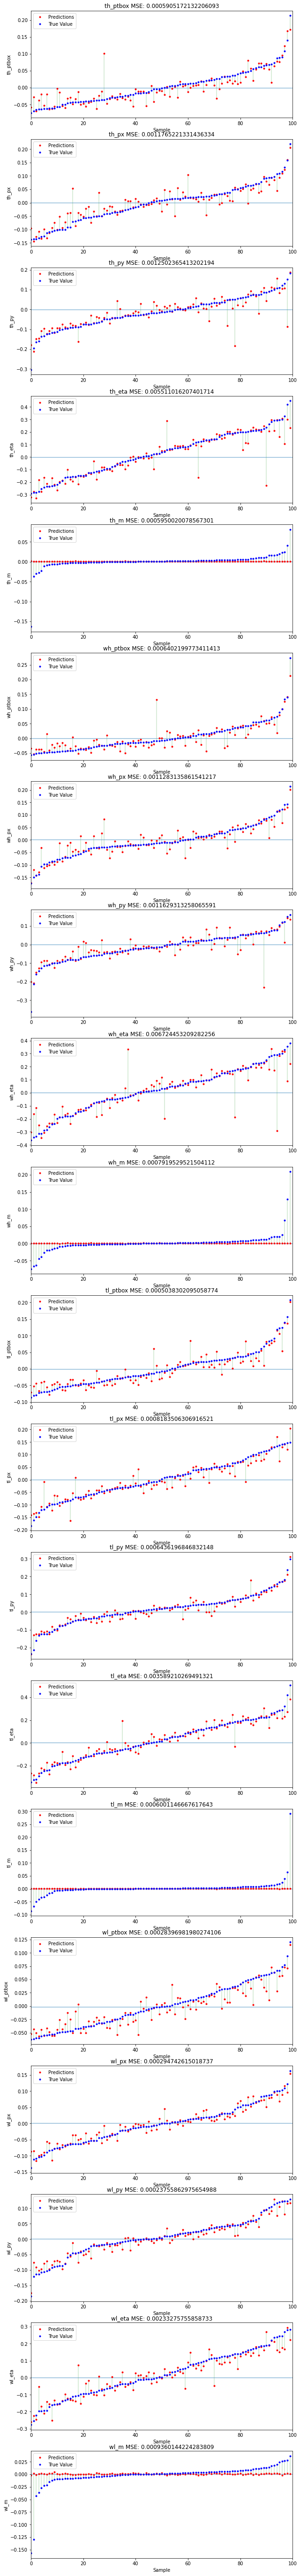

In [15]:
Analysis.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

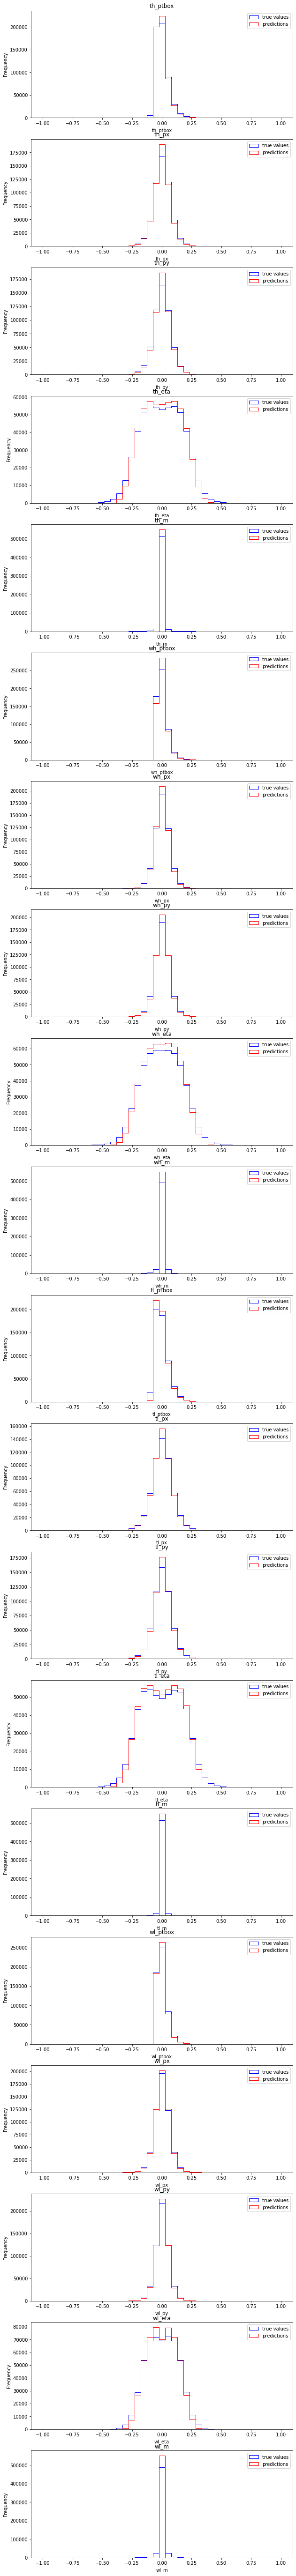

In [16]:
Analysis.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

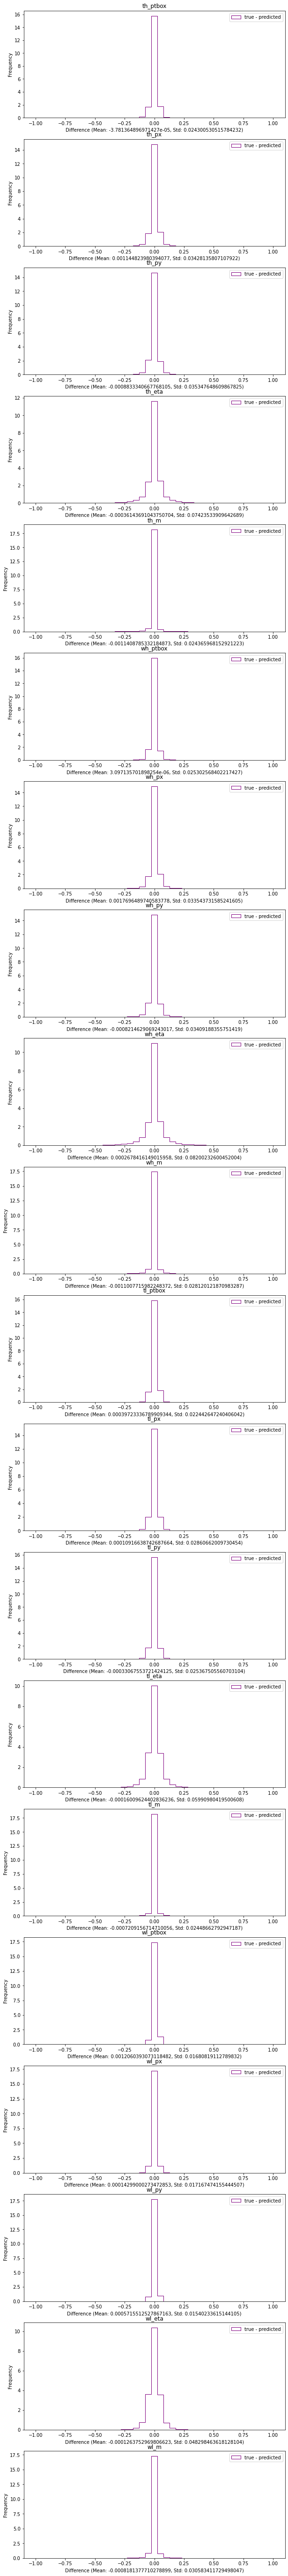

In [17]:
Analysis.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

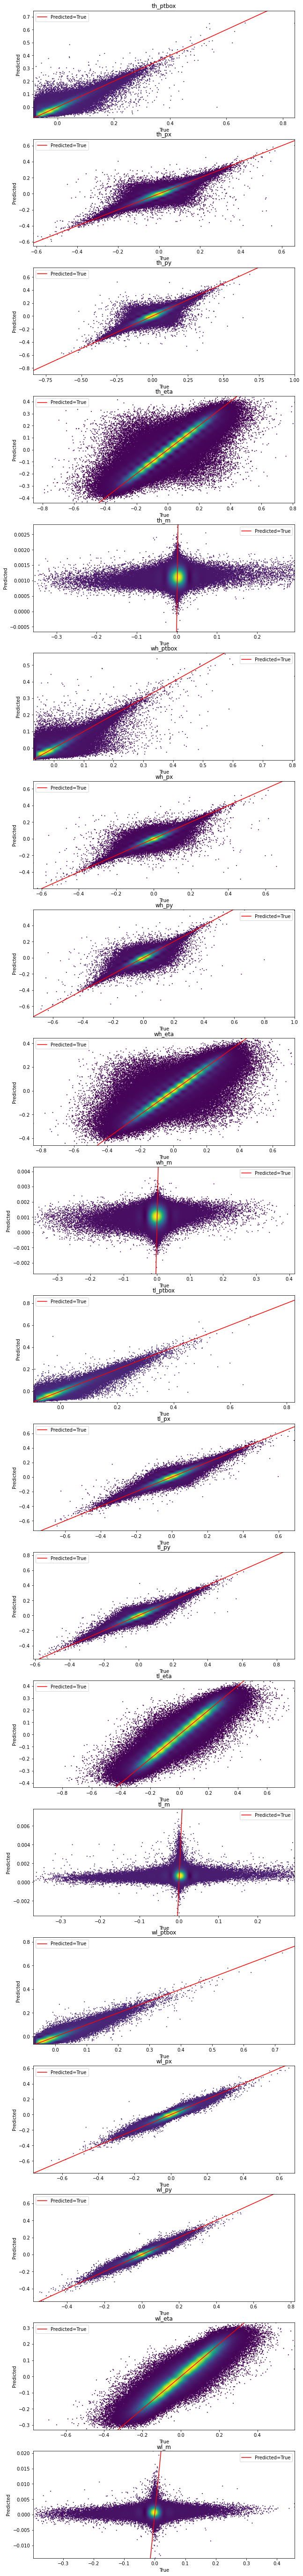

In [18]:
Analysis.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

## Original Scale Plots

In [19]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 314.3205270460374
 
th_pt MSE, MAE :  1732.6124104923 27.9353401844
th_eta MSE, MAE :  0.4626754167 0.3738522756
th_phi MSE, MAE :  0.6866349035 0.4512492180
th_m MSE, MAE :  35.4098365981 2.1311664302
wh_pt MSE, MAE :  1286.2423719229 22.6259553042
wh_eta MSE, MAE :  0.5345170372 0.4098752913
wh_phi MSE, MAE :  0.6428736044 0.4498315429
wh_m MSE, MAE :  35.9038788173 2.6179906413
tl_pt MSE, MAE :  1231.4893837366 25.0728812872
tl_eta MSE, MAE :  0.2980588977 0.3580316425
tl_phi MSE, MAE :  0.4200036102 0.3419498061
tl_m MSE, MAE :  35.7137175937 2.1305036334
wl_pt MSE, MAE :  625.3593680155 18.3292023645
wl_eta MSE, MAE :  0.2977466943 0.3834385222
wl_phi MSE, MAE :  0.1964508849 0.2496319416
wl_m MSE, MAE :  37.3047056386 2.6524306335


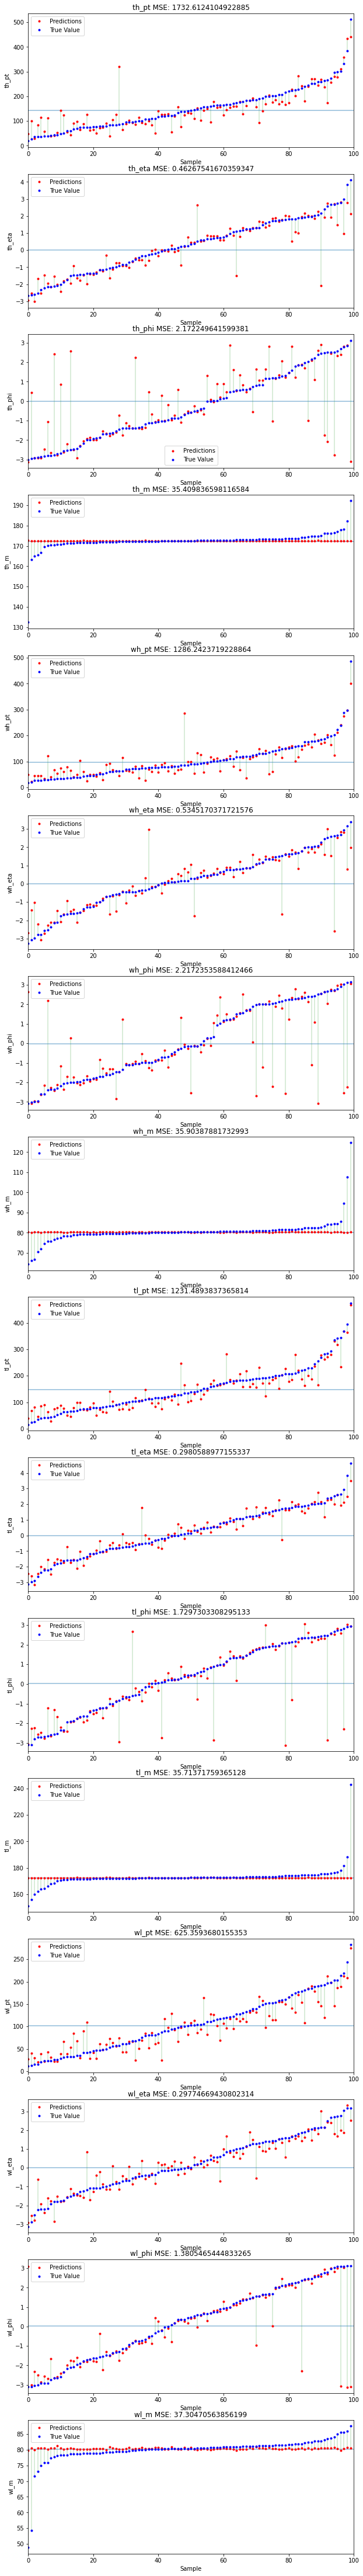

In [20]:
Analysis.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

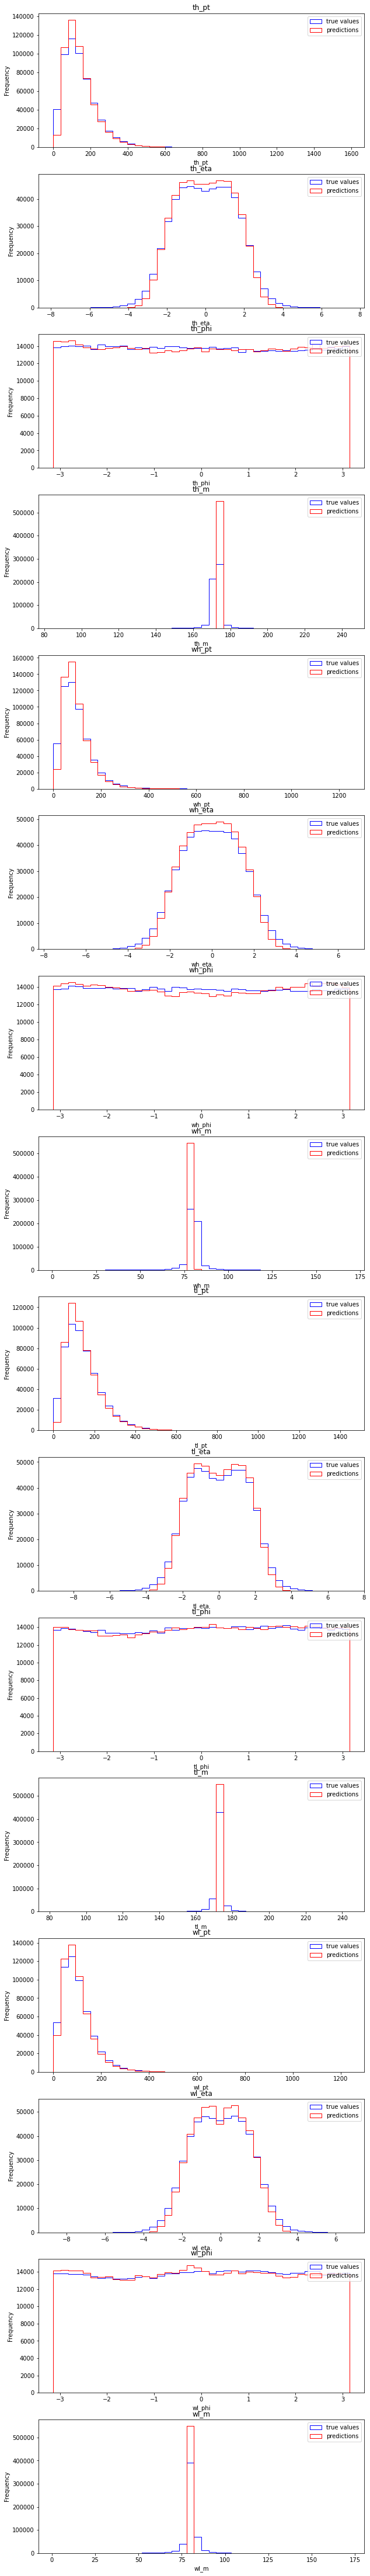

In [21]:
Analysis.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


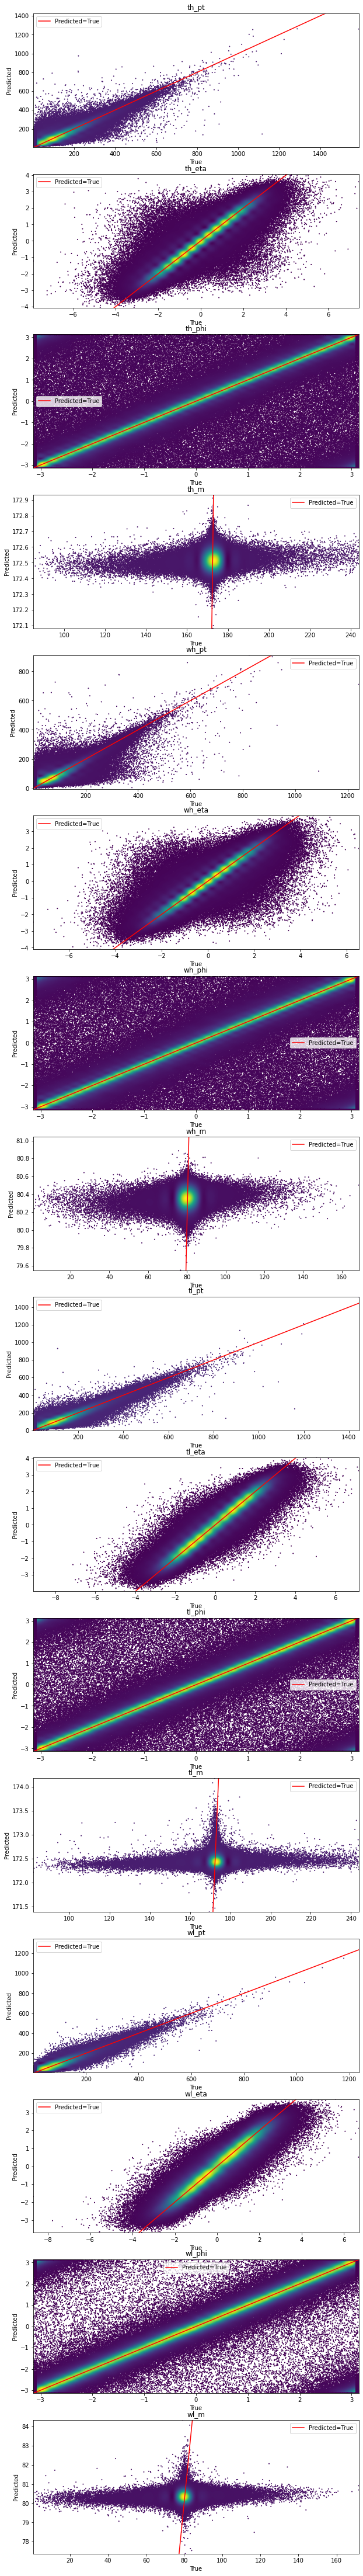

In [22]:
Analysis.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)

## Observables

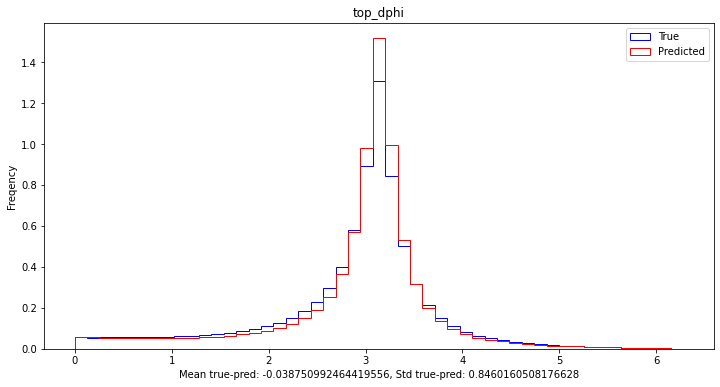

In [23]:
import observables 
import importlib
importlib.reload(observables)
truths = observables.fill_observables(true_origscale, True, Y_keys)
preds = observables.fill_observables(predictions_origscale, False, Y_keys)

# top_dphi=np.abs(th_phi-tl_phi)
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_dphi'], preds['top_dphi'])

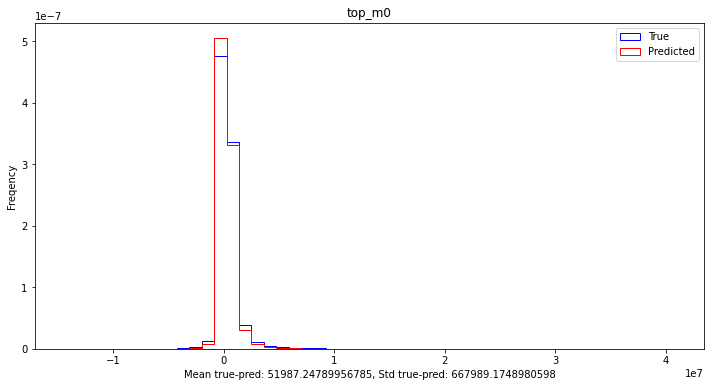

In [24]:
# top_m0= th_m**2-th_p**2 + tl_m**2-tl_p**2
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_m0'],preds['top_m0'])

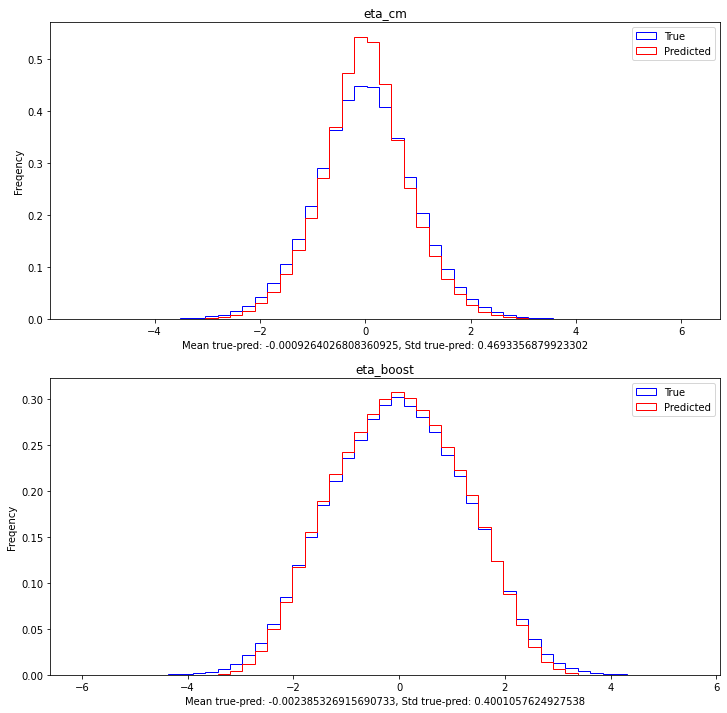

In [25]:
# eta_cm=0.5*(th_eta-tl_eta), eta_boost=0.5*(th_eta+tl_eta)
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['eta_cm'], preds['eta_cm'])
plt.subplot(212)
observables.plot_hist(truths['eta_boost'], preds['eta_boost'])

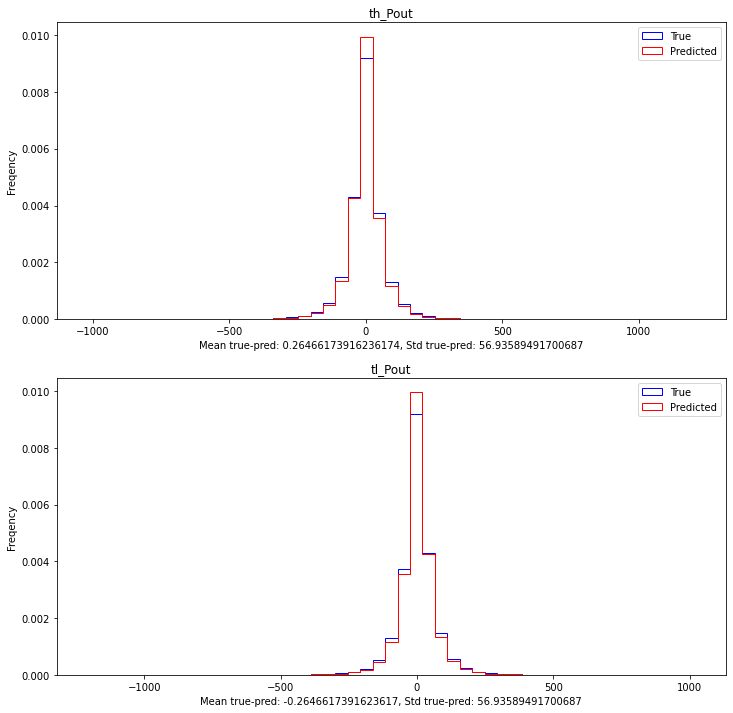

In [26]:
# th_Pout=dot(th_P, cross(tl_P,ez)/norm(tl_P,ez)), tl_Pout=dot(tl_P, cross(th_P,ez)/norm(th_P,ez))
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['th_Pout'], preds['th_Pout'])
plt.subplot(212)
observables.plot_hist(truths['tl_Pout'], preds['tl_Pout'])

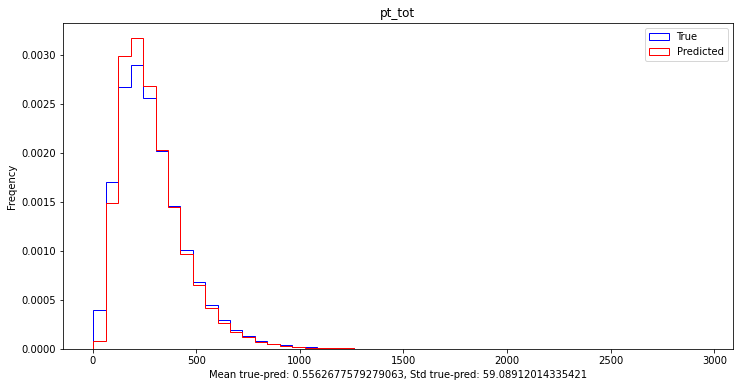

In [27]:
# pt_tot = th_pt+tl_pt
plt.figure(figsize=(12,6))
observables.plot_hist(truths['pt_tot'],preds['pt_tot'])